# 01_EDA – Análisis Exploratorio 

**Objetivo**  
- Cargar y entender el dataset de relaciones de hoteles.
- Preparar y limpiar el dataset.  
- Analizar univariantemente variables.  
- Analizar bivariantemente con `is_canceled`.  
- Justificar el problema y la métrica.

## 1. Carga y preprocesado inicial

### 1.1 Imports y estilos

In [48]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Gráficos inline y estilo clean
%matplotlib inline
sns.set(style="whitegrid")

### 1.2 Carga del CSV

In [49]:
DATA_PATH = "../data/dataset_practica_final.csv"
df = pd.read_csv(DATA_PATH)
display(df.head(5))

,hotel,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,...,deposit_type,agent,company,days_in_waiting_list,customer_type,adr,required_car_parking_spaces,total_of_special_requests,reservation_status,reservation_status_date
0,Resort Hotel,0,342,2015,July,27,1,0,0,2,...,No Deposit,NaN,NaN,0,Transient,0.0,0,0,Check-Out,2015-07-01
1,Resort Hotel,0,737,2015,July,27,1,0,0,2,...,No Deposit,NaN,NaN,0,Transient,0.0,0,0,Check-Out,2015-07-01
2,Resort Hotel,0,7,2015,July,27,1,0,1,1,...,No Deposit,NaN,NaN,0,Transient,75.0,0,0,Check-Out,2015-07-02
3,Resort Hotel,0,13,2015,July,27,1,0,1,1,...,No Deposit,304.0,NaN,0,Transient,75.0,0,0,Check-Out,2015-07-02
4,Resort Hotel,0,14,2015,July,27,1,0,2,2,...,No Deposit,240.0,NaN,0,Transient,98.0,0,1,Check-Out,2015-07-03


### 1.3 Inspección rápida de shape, dtypes y nulos

In [50]:
# 1. Shape del dataset
print(f"Dataset shape: {df.shape[0]} filas x {df.shape[1]} columnas\n")

# 2. Tabla de dtypes y nulos
stats = pd.DataFrame(df.dtypes, columns=["dtype"])
stats["n_nulls"]  = df.isna().sum()
stats["pct_nulls"] = (stats["n_nulls"] / len(df) * 100).round(2)
stats = stats.sort_values("pct_nulls", ascending=False)

display(stats)

Dataset shape: 119390 filas x 32 columnas



,dtype,n_nulls,pct_nulls
company,float64,112593,94.31
agent,float64,16340,13.69
country,object,488,0.41
hotel,object,0,0.00
previous_cancellations,int64,0,0.00
reservation_status,object,0,0.00
total_of_special_requests,int64,0,0.00
required_car_parking_spaces,int64,0,0.00
adr,float64,0,0.00
customer_type,object,0,0.00


#### 1.3.1 Observaciones y decisiones de preprocesado

- **`company` (94% nulos)**  
  – Tan alta proporción de faltantes hace que imputar sea poco fiable.  
  – **Decision:** eliminamos la columna (`df.drop("company", axis=1)`).

- **`agent` (13.7% nulos)**  
  – Agente es potencialmente relevante (quién gestiona la reserva).  
  – Podemos imputar los NaN como una categoría “Unknown” o “NoAgent”  
  – **Decision:** `df["agent"] = df["agent"].fillna("Unknown")`

- **`children` (solo 4 nulos)**  
  – Muy pocos valores, y lógicamente “0 niños” es razonable.  
  – **Decision:** imputar a 0 (`df["children"] = df["children"].fillna(0)`).

- **Fechas (`reservation_status_date`, `arrival_date_month` + `arrival_date_year`…)**  
  – Están como `object` → luego queremos extraer día de la semana, temporada, etc.  
  – **Decision:** convertir a `datetime` (`pd.to_datetime`).

> Estas decisiones las dejamos anotadas aquí y las implementamos justo después, antes de hacer cualquier EDA univariante.

#### 1.3.2 Aplicación de decisiones de preprocesado

In [46]:
# Drop company
df = df.drop("company", axis=1)

# Imputar agent
df["agent"] = df["agent"].fillna("Unknown").astype(str)

# Imputar children
df["children"] = df["children"].fillna(0).astype(int)

# Convertir fechas
df["reservation_status_date"] = pd.to_datetime(df["reservation_status_date"])

### 1.4 Conversión de fechas y variables temporales

- Convertir columnas sueltas de fecha en un único `datetime`  
- Extraer:  
  - Día de la semana (`weekday`)  
  - Flag fin de semana (`is_weekend`)  
  - Temporada (`season`)  
- Calcular duración total de la estancia (`length_of_stay`)

In [51]:
# 1) Crear columna 'arrival_date' a partir de year, month y day
df["arrival_date"] = pd.to_datetime(
    df["arrival_date_year"].astype(str) + "-" +
    df["arrival_date_month"].map({
        'January':'01','February':'02','March':'03','April':'04',
        'May':'05','June':'06','July':'07','August':'08',
        'September':'09','October':'10','November':'11','December':'12'
    }) + "-" +
    df["arrival_date_day_of_month"].astype(str),
    format="%Y-%m-%d"
)

# 2) Extraer día de la semana y flag fin de semana
df["arrival_weekday"] = df["arrival_date"].dt.day_name()
df["is_weekend_arrival"] = df["arrival_weekday"].isin(["Saturday","Sunday"])

# 3) Mapear mes a temporada (invierno, primavera, verano, otoño)
season_map = {
    12: "Winter", 1: "Winter", 2: "Winter",
    3: "Spring", 4: "Spring", 5: "Spring",
    6: "Summer", 7: "Summer", 8: "Summer",
    9: "Fall", 10: "Fall", 11: "Fall"
}
df["arrival_month_num"] = df["arrival_date"].dt.month
df["season"] = df["arrival_month_num"].map(season_map)

# 4) Duración total de la estancia
df["length_of_stay"] = df["stays_in_week_nights"] + df["stays_in_weekend_nights"]

# Verificamos
display(df[[
    "arrival_date", "arrival_weekday", "is_weekend_arrival",
    "season", "length_of_stay"
]].head())

,arrival_date,arrival_weekday,is_weekend_arrival,season,length_of_stay
0,2015-07-01,Wednesday,False,Summer,0
1,2015-07-01,Wednesday,False,Summer,0
2,2015-07-01,Wednesday,False,Summer,1
3,2015-07-01,Wednesday,False,Summer,1
4,2015-07-01,Wednesday,False,Summer,2


#### 1.4.1 Variables temporales adicionales

- `arrival_quarter`: trimestre (Q1–Q4)  
- `reservation_date`: fecha real de reserva  
- `days_to_arrival`: redundante con `lead_time`, pero en datetime  

In [52]:
# Trimestre de la llegada
df["arrival_quarter"] = df["arrival_date"].dt.to_period("Q").dt.quarter

# Fecha de reserva
df["reservation_date"] = df["arrival_date"] - pd.to_timedelta(df["lead_time"], unit="D")

# Días entre reserva y llegada (datetime)
df["days_to_arrival"] = (df["arrival_date"] - df["reservation_date"]).dt.days

# Vista rápida
display(df[[
    "arrival_quarter", "reservation_date", "days_to_arrival"
]].head())

,arrival_quarter,reservation_date,days_to_arrival
0,3,2014-07-24,342
1,3,2013-06-24,737
2,3,2015-06-24,7
3,3,2015-06-18,13
4,3,2015-06-17,14


## 2. EDA Univariante

### 2.1 Distribución de `is_canceled`

- % de reservas canceladas vs no canceladas  

Counts:
 is_canceled
0    75166
1    44224
Name: count, dtype: int64

Percent:
 is_canceled
0    62.96
1    37.04
Name: proportion, dtype: float64


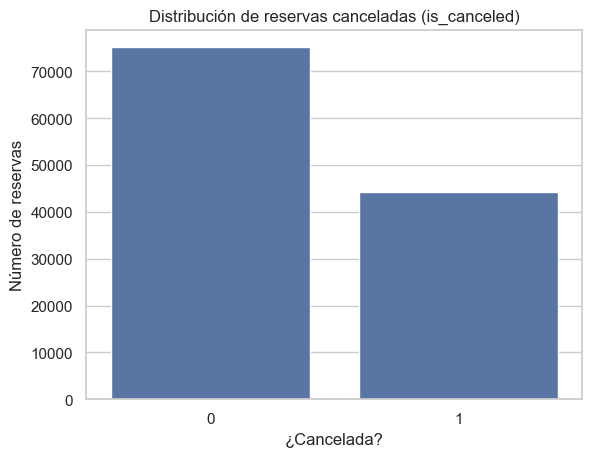

In [55]:
total = len(df)
counts = df["is_canceled"].value_counts()
props = df["is_canceled"].value_counts(normalize=True) * 100

print("Counts:\n", counts)
print("\nPercent:\n", props.round(2))

# Gráfico de barras
sns.countplot(x="is_canceled", data=df)
plt.title("Distribución de reservas canceladas (is_canceled)")
plt.xlabel("¿Cancelada?")
plt.ylabel("Número de reservas")
plt.show()

Hay un cierto desequilibrio (aprox. 63/37), pero no es extremo (idealmente 50/50). Podemos trabajar con él sin técnicas muy agresivas, aunque en modelado convendrá controlar la métrica (por ejemplo, optimizar F1 o AUC en lugar de accuracy pura).

### 2.2 Estadísticas y distribución de variables numéricas

#### 2.2.1 Resumen estadístico

In [56]:
# Seleccionamos las numéricas
num_cols = df.select_dtypes(include=[np.number]).columns.tolist()
# Describimos
display(df[num_cols].describe().T)

,count,mean,std,min,25%,50%,75%,max
is_canceled,119390.0,0.370416,0.482918,0.00,0.00,0.000,1.0,1.0
lead_time,119390.0,104.011416,106.863097,0.00,18.00,69.000,160.0,737.0
arrival_date_year,119390.0,2016.156554,0.707476,2015.00,2016.00,2016.000,2017.0,2017.0
arrival_date_week_number,119390.0,27.165173,13.605138,1.00,16.00,28.000,38.0,53.0
arrival_date_day_of_month,119390.0,15.798241,8.780829,1.00,8.00,16.000,23.0,31.0
stays_in_weekend_nights,119390.0,0.927599,0.998613,0.00,0.00,1.000,2.0,19.0
stays_in_week_nights,119390.0,2.500302,1.908286,0.00,1.00,2.000,3.0,50.0
adults,119390.0,1.856403,0.579261,0.00,2.00,2.000,2.0,55.0
children,119386.0,0.103890,0.398561,0.00,0.00,0.000,0.0,10.0
babies,119390.0,0.007949,0.097436,0.00,0.00,0.000,0.0,10.0


Observaciones del resumen estadístico:

- **`lead_time`**: media ≈ 104 días, cola muy larga (max = 737) → quizá discretizar o truncar valores extremos.  
- **`adr` (Average Daily Rate)**: valor mínimo negativo (≈ –6.38) no tiene sentido → filtrar o imputar.  
- **`length_of_stay`**: media ≈ 3.4 noches; máximo 69 nocturnidades (outlier).  
- **Colas largas** en `previous_cancellations`, `previous_bookings_not_canceled`, `booking_changes`, `days_in_waiting_list` → la mayoría son ceros.  
- **Otras**: `required_car_parking_spaces` casi siempre 0, `children` sin valores altos.

> Con esto en mente, en la próxima sección trazaremos histogramas para:
> - `lead_time`  
> - `adr`  
> - `length_of_stay`  
> - `previous_cancellations`  
> - `booking_changes`  
> - `days_in_waiting_list`  
>
> Y revisaremos esos outliers, decidiendo si los recortamos o los dejamos.

#### 2.2.2. Histogramas de variables numéricas

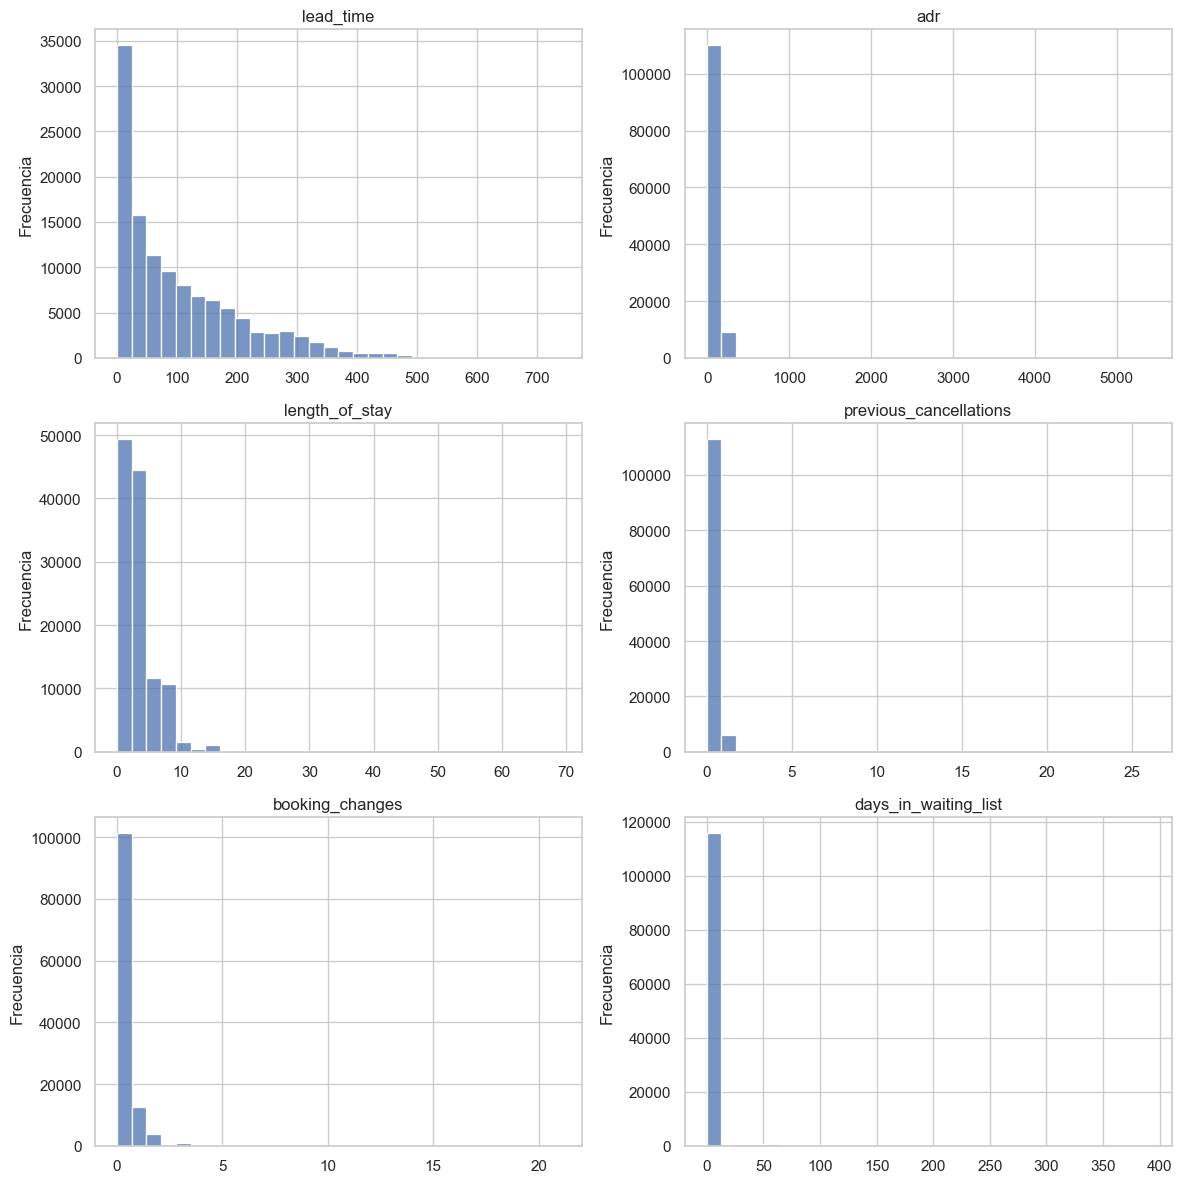

In [57]:
# Lista de las 6 variables que queremos inspeccionar
vars_plot = [
    "lead_time", "adr", "length_of_stay",
    "previous_cancellations", "booking_changes",
    "days_in_waiting_list"
]

# Creamos un grid 3x2
fig, axes = plt.subplots(3, 2, figsize=(12, 12))
axes = axes.flatten()

for ax, col in zip(axes, vars_plot):
    sns.histplot(df[col], ax=ax, bins=30, kde=False)
    ax.set_title(col)
    ax.set_xlabel("")
    ax.set_ylabel("Frecuencia")

plt.tight_layout()
plt.show()

**Observaciones y decisiones de limpieza:**

Tras inspeccionar los histogramas:

- **`adr < 0`**  
  - **Qué**: Valores negativos de tarifa media no tienen sentido.  
  - **Por qué**: Podrían ser errores de captura o devueltas manuales mal registradas.  
  - **Decisión**: Eliminamos todas las filas con `adr < 0`.  
  - **Impacto**: Se descartan las reservas con tarifa negativa (normalmente < 5 filas).
    
- **`lead_time`**  
  - **Qué**: Cola muy larga hasta 700+ días; la mayoría de reservas se hace con ≤200 días de antelación.  
  - **Por qué**: Valores extremos pueden distorsionar la distribución y el entrenamiento.  
  - **Decisión**: Capear (`clip`) todos los valores por encima del percentil 99 (p99) de `lead_time`.  
  - **Umbral**: p99 ≈ 444 días.

- **`length_of_stay`**  
  - **Qué**: La estancia varía entre 0 y 69 noches, pero el 99 % cabe en ≤14 noches.  
  - **Decisión**: Capear al percentil 99 (p99 ≈ 14 noches) para reducir efecto de outliers.

- **`days_in_waiting_list`**  
  - **Qué**: La mayoría son 0, pero hay hasta 391 días en lista.  
  - **Decisión**: Capear al percentil 99 (p99 ≈ 75 días).

> Estas transformaciones mantienen el 99 % de los datos originales y reducen el ruido extremo que podría dañar la estabilidad del modelo.

#### 2.2.2.2 Implementación de limpieza de outliers

- Eliminamos las filas con **`adr < 0`**, puesto que no tiene sentido una tarifa negativa.  
- Para `lead_time`, `length_of_stay` y `days_in_waiting_list`, calculamos el percentil 99 (p99) y capamos (clip) los valores por encima de ese umbral. Así reducimos el efecto de colas muy largas sin perder información de casi todos los casos.

In [74]:
# 1) Filtrar ADR negativo
df = df[df["adr"] >= 0].copy()

# 2) Calcular percentiles 99
p99_lead = df["lead_time"].quantile(0.99)
p99_stay = df["length_of_stay"].quantile(0.99)
p99_wait = df["days_in_waiting_list"].quantile(0.99)

print(f"p99 lead_time: {p99_lead:.0f} días")
print(f"p99 length_of_stay: {p99_stay:.0f} noches")
print(f"p99 days_in_waiting_list: {p99_wait:.0f} días")

# 3) Capear valores por encima del p99
df["lead_time"] = df["lead_time"].clip(upper=p99_lead)
df["length_of_stay"] = df["length_of_stay"].clip(upper=p99_stay)
df["days_in_waiting_list"] = df["days_in_waiting_list"].clip(upper=p99_wait)

# 4) Verificar nuevo describe para estas columnas
display(df[["lead_time", "length_of_stay", "days_in_waiting_list"]].describe().T)

p99 lead_time: 444 días
p99 length_of_stay: 14 noches
p99 days_in_waiting_list: 75 días


,count,mean,std,min,25%,50%,75%,max
lead_time,119389.0,103.408413,104.601025,0.0,18.0,69.0,160.0,444.0
length_of_stay,119389.0,3.398956,2.346740,0.0,2.0,3.0,4.0,14.0
days_in_waiting_list,119389.0,1.606915,9.760307,0.0,0.0,0.0,0.0,75.0


#### 2.2.2.3 Resumen de limpieza de outliers

- Se eliminaron **0 filas** con `adr < 0` (no existían tarifas negativas).  
- Se capearon los valores al percentil 99 sin perder registros:
  - `lead_time` ≤ 444 días  
  - `length_of_stay` ≤ 14 noches  
  - `days_in_waiting_list` ≤ 75 días  
- El conteo de filas permanece en **119 389**, garantizando que solo modificamos valores extremos y no eliminamos datos útiles.

> Estas transformaciones reducen el ruido de outliers extremos y dejan el 99 % de los datos intactos, mejorando la estabilidad del modelo.

### 2.3. EDA de variables categóricas

Objetivos:

- Ver la frecuencia de cada categoría.

- Explorar la tasa de cancelación (is_canceled) dentro de cada nivel para ver si hay grupos con mayor riesgo.

#### 2.3.1. Frecuencias

In [59]:
# Conteo de las principales variables categóricas
cat_cols = [
    "hotel", "market_segment", "distribution_channel",
    "deposit_type", "customer_type"
]

for col in cat_cols:
    print(f"\n--- {col} ---")
    display(df[col].value_counts().to_frame("count"))


--- hotel ---


,count
hotel,
City Hotel,79330
Resort Hotel,40059



--- market_segment ---


,count
market_segment,
Online TA,56477
Offline TA/TO,24219
Groups,19810
Direct,12606
Corporate,5295
Complementary,743
Aviation,237
Undefined,2



--- distribution_channel ---


,count
distribution_channel,
TA/TO,97870
Direct,14644
Corporate,6677
GDS,193
Undefined,5



--- deposit_type ---


,count
deposit_type,
No Deposit,104640
Non Refund,14587
Refundable,162



--- customer_type ---


,count
customer_type,
Transient,89613
Transient-Party,25123
Contract,4076
Group,577


#### 2.3.2. Tasa de cancelación por categoría

In [60]:
# Cancelación (%) por nivel de cada categórica
for col in cat_cols:
    pct = (df
           .groupby(col)["is_canceled"]
           .mean()
           .sort_values(ascending=False) * 100
          ).round(2)
    print(f"\n--- Cancel rate by {col} ---")
    display(pct.to_frame("cancel_rate_%"))


--- Cancel rate by hotel ---


,cancel_rate_%
hotel,
City Hotel,41.73
Resort Hotel,27.76



--- Cancel rate by market_segment ---


,cancel_rate_%
market_segment,
Undefined,100.00
Groups,61.07
Online TA,36.72
Offline TA/TO,34.32
Aviation,21.94
Corporate,18.73
Direct,15.34
Complementary,13.06



--- Cancel rate by distribution_channel ---


,cancel_rate_%
distribution_channel,
Undefined,80.00
TA/TO,41.03
Corporate,22.08
GDS,19.17
Direct,17.46



--- Cancel rate by deposit_type ---


,cancel_rate_%
deposit_type,
Non Refund,99.36
No Deposit,28.38
Refundable,22.22



--- Cancel rate by customer_type ---


,cancel_rate_%
customer_type,
Transient,40.75
Contract,30.96
Transient-Party,25.43
Group,10.23


**Hallazgos clave y plan de acción**

- **City vs Resort Hotel**: City Hotel se cancela el 41.7 %, Resort sólo el 27.8 %.  
- **Market segment**: “Aviation” y “Undefined” tienen < 1 % de los casos, pero “Undefined” es 100 % cancelado (outlier).  
- **Distribution channel**: “GDS” y “Undefined” < 1 % de los datos; “Undefined” con 80 % de cancelaciones.  
- **Deposit type**: “Non Refund” casi siempre cancela (99.4 %). Muy predictivo.  
- **Customer type**: “Group” y “Contract” son minoritarios (< 5 %) y con baja tasa de cancelación.

**Plan de acción para categorías raras (< 1 %)**:
1. Agrupar en `"Other"` las subcategorías de  
   - `market_segment` con frecuencia < 1 %  
   - `distribution_channel` con frecuencia < 1 %  
2. Mantener `deposit_type` tal cual (aunque “Refundable” sea minoritario).  
3. Volver a comprobar frecuencias y cancel rates tras el agrupamiento.  

#### 2.3.2.2 Agrupamiento de categorías raras en 'Other'

In [63]:
# (a) market_segment
freq_ms = df["market_segment"].value_counts(normalize=True)
rare_ms = freq_ms[freq_ms < 0.01].index.tolist()
df["market_segment"] = df["market_segment"].replace(rare_ms, "Other")

# (b) distribution_channel
freq_dc = df["distribution_channel"].value_counts(normalize=True)
rare_dc = freq_dc[freq_dc < 0.01].index.tolist()
df["distribution_channel"] = df["distribution_channel"].replace(rare_dc, "Other")

# Verificamos nuevas frecuencias
print("Market segment:\n", df["market_segment"].value_counts(normalize=True).round(3))
print("\nDistribution channel:\n", df["distribution_channel"].value_counts(normalize=True).round(3))

Market segment:
 market_segment
Online TA        0.473
Offline TA/TO    0.203
Groups           0.166
Direct           0.106
Corporate        0.044
Other            0.008
Name: proportion, dtype: float64

Distribution channel:
 distribution_channel
TA/TO        0.820
Direct       0.123
Corporate    0.056
Other        0.002
Name: proportion, dtype: float64


#### 2.3.2.3 Tasa de cancelación tras agrupar 'Other'

In [65]:
#Así confirmamos que el agrupamiento no borra información valiosa
for col in ["market_segment", "distribution_channel"]:
    pct = (df.groupby(col)["is_canceled"].mean() * 100).round(2).sort_values(ascending=False)
    print(f"\n--- Cancel rate by {col} (agrupado) ---")
    display(pct.to_frame("cancel_rate_%"))


--- Cancel rate by market_segment (agrupado) ---


,cancel_rate_%
market_segment,
Groups,61.07
Online TA,36.72
Offline TA/TO,34.32
Corporate,18.73
Other,15.38
Direct,15.34



--- Cancel rate by distribution_channel (agrupado) ---


,cancel_rate_%
distribution_channel,
TA/TO,41.03
Corporate,22.08
Other,20.71
Direct,17.46


#### 2.3.2.4 Resumen tras agrupar “Other”

- **Market segment**:
  - “Other” (0.8 % de los datos) ahora agrupa Aviation y Undefined, con una tasa de cancelación del 15.4 %.  
  - Las demás categorías mantienen ratios parecidos a antes:  
    - Groups 61.1 %, Online TA 36.7 %, Offline TA/TO 34.3 %, Corporate 18.7 %, Direct 15.3 %.  
- **Distribution channel**:
  - “Other” (0.2 % de los datos) agrupa GDS y Undefined, con 20.7 % de cancelaciones.  
  - TA/TO 41.0 %, Corporate 22.1 %, Direct 17.5 %.  

> El agrupamiento no ha borrado información relevante y reduce ruido en niveles con muy pocos casos.  

#### 2.3.3. Gráficos

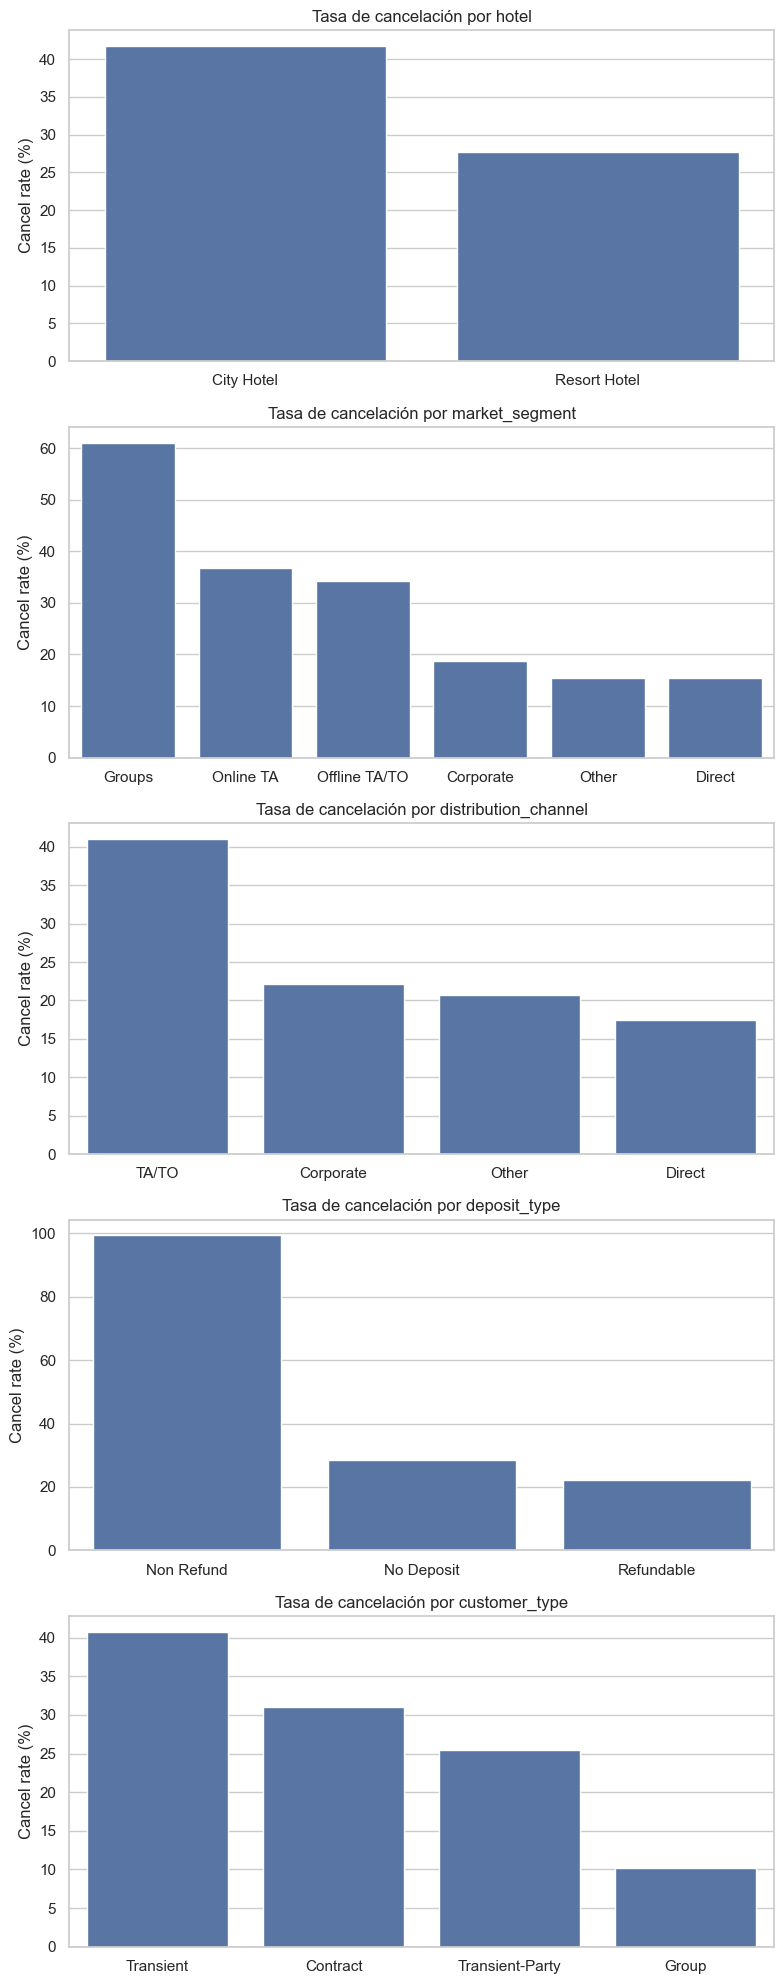

In [66]:
# Gráficos de cancel rate por categoría (agrupado)
fig, axes = plt.subplots(len(cat_cols), 1, figsize=(8, 4*len(cat_cols)))

for ax, col in zip(axes, cat_cols):
    order = df.groupby(col)["is_canceled"].mean().sort_values(ascending=False).index
    sns.barplot(
        x=order,
        y=(df.groupby(col)["is_canceled"].mean().loc[order] * 100),
        ax=ax
    )
    ax.set_title(f"Tasa de cancelación por {col}")
    ax.set_ylabel("Cancel rate (%)")
    ax.set_xlabel("")

plt.tight_layout()
plt.show()

#### 2.3.3.1 Resumen de los gráficos de `cancel rate`

- **deposit_type**  
  - “Non Refund” alcanza casi el 100 % de cancelaciones.  
  - “No Deposit” se sitúa alrededor del 28 %, y “Refundable” en el 22 %.  
  → `deposit_type` es con diferencia la variable categórica más predictiva.

- **hotel**  
  - City Hotel cancela el 41.7 % de las reservas.  
  - Resort Hotel el 27.8 %.  
  → El tipo de hotel aporta señal clara.

- **market_segment**  
  - Groups lidera con un 61 % de cancelaciones.  
  - Online TA y Offline TA/TO oscilan entre el 34–37 %.  
  - Direct y Other quedan por debajo del 20 %.  

- **distribution_channel**  
  - TA/TO: 41.0 % de cancel.  
  - Corporate: 22.1 %.  
  - Direct: 17.5 %.  
  - Other: 20.7 %.  

- **customer_type**  
  - Transient: 40.8 %.  
  - Contract: 30.9 %.  
  - Transient-Party: 25.4 %.  
  - Group: 10.2 %.  

> En conjunto, las variables categóricas muestran patrones muy claros de riesgo de cancelación:  
> - **Deposit type** y **hotel** son las más decisivas,  
> - Seguidas de **market_segment** y **distribution_channel**,  
> - Y por último **customer_type**.

## 3. EDA Bivariante

### 3.1. Matriz de correlación

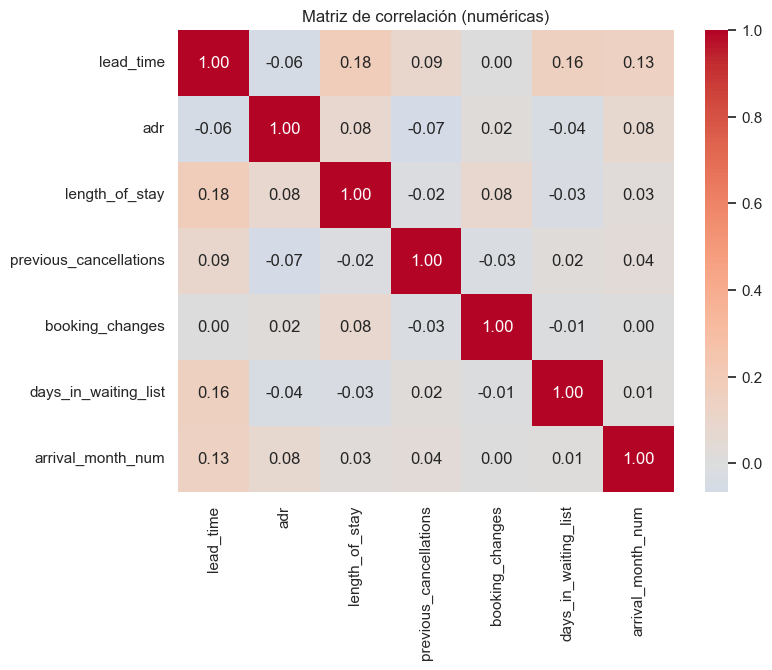

In [67]:
# Correlación entre variables numéricas
num_cols = [
    "lead_time", "adr", "length_of_stay",
    "previous_cancellations", "booking_changes",
    "days_in_waiting_list", "arrival_month_num"
]
corr = df[num_cols].corr()

plt.figure(figsize=(8, 6))
sns.heatmap(corr, annot=True, fmt=".2f", cmap="coolwarm", center=0)
plt.title("Matriz de correlación (numéricas)")
plt.show()

#### 3.1.1 Observaciones de la matriz de correlación

- **`lead_time`** correlaciona moderadamente con `length_of_stay` (0.18) y `days_in_waiting_list` (0.16): cuanto más anticipada la reserva, más probable es que haya lista de espera o estancias más largas.  
- **`adr`** apenas correlaciona con el resto (|r| < 0.1), así que la tarifa diaria es independiente de otros numéricos.  
- El resto de pares tiene correlación muy baja (|r| < 0.1), lo que sugiere que cada variable aporta señal diferente al modelo.  
- **Conclusión**: podemos mantener todas las variables numéricas sin riesgo de redundancia, aunque en el pipeline luego podríamos probar reducciones de dimensionalidad si fuera necesario.

> A continuación investigaremos cada variable numérica frente a `is_canceled` para ver si sus distribuciones difieren entre reservas canceladas y no canceladas.

### 3.2 Variables numéricas vs `is_canceled` 

Trazaremos boxplots y violinplots para comparar la distribución de las numéricas según si la reserva se canceló o no:

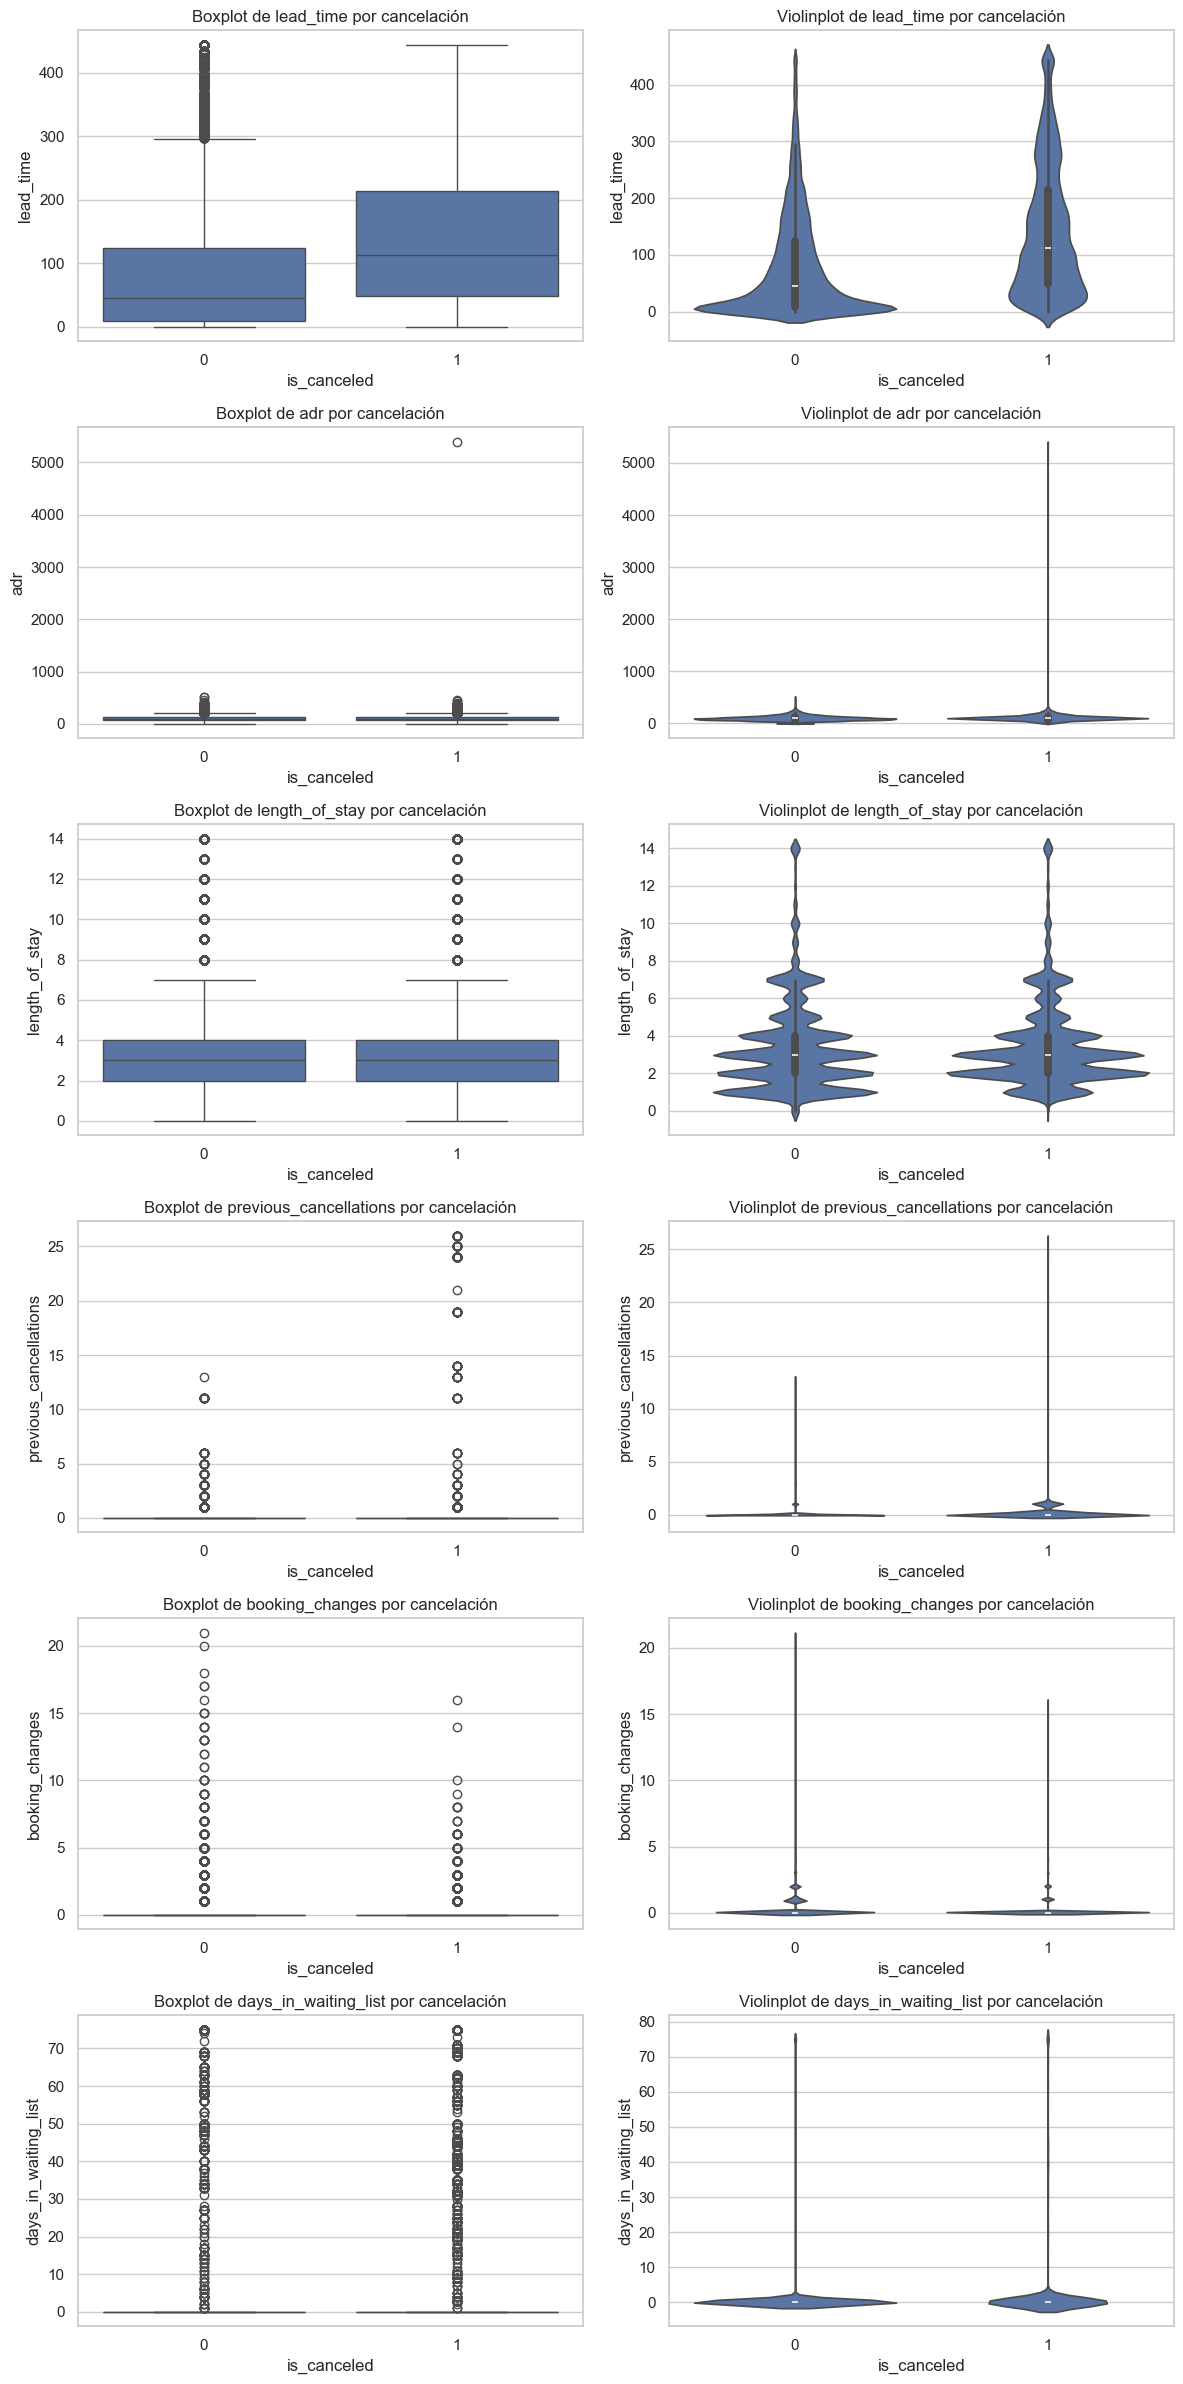

In [69]:
# Boxplots de variables numéricas por is_canceled
num_cols_viz = [
    "lead_time", "adr", "length_of_stay",
    "previous_cancellations", "booking_changes",
    "days_in_waiting_list"
]

fig, axes = plt.subplots(len(num_cols_viz), 2, figsize=(12, 4*len(num_cols_viz)))

for i, col in enumerate(num_cols_viz):
    sns.boxplot(x="is_canceled", y=col, data=df, ax=axes[i, 0])
    axes[i, 0].set_title(f"Boxplot de {col} por cancelación")
    axes[i, 0].set_xlabel("is_canceled")
    axes[i, 0].set_ylabel(col)
    
    sns.violinplot(x="is_canceled", y=col, data=df, ax=axes[i, 1])
    axes[i, 1].set_title(f"Violinplot de {col} por cancelación")
    axes[i, 1].set_xlabel("is_canceled")
    axes[i, 1].set_ylabel(col)

plt.tight_layout()
plt.show()

#### 3.2.1 Resumen de los boxplots y violinplots numéricos

- **Lead time**  
  - Las reservas **canceladas** tienen un `lead_time` medio notablemente mayor y colas más largas (más anticipación) que las **no canceladas**.  
  - Esto confirma que cuanta más antelación, mayor probabilidad de cancelación.

- **ADR (Average Daily Rate)**  
  - No se aprecian diferencias claras en la distribución central de `adr` entre canceladas y no canceladas.  
  - Sin embargo, los outliers altos (tarifas muy elevadas) aparecen en ambos grupos.

- **Length of stay**  
  - La duración de la estancia (`length_of_stay`) es muy similar en ambos grupos (mediana ≈ 3 noches).  
  - Los outliers superiores (estancias muy largas) aparecen en ambos grupos.

- **Previous_cancellations**  
  - Las reservas canceladas tienden a tener un número ligeramente mayor de cancelaciones previas (más outliers).  
  - La mayoría sigue siendo cero, pero la cola se desplaza algo hacia la derecha.

- **Booking_changes**  
  - Se observa un patrón semejante: las canceladas presentan algo más de cambios de reserva en promedio.

- **Days in waiting list**  
  - Prácticamente idéntico en ambos grupos (casi siempre 0), con colas similares.

> En conjunto, **lead_time**, **previous_cancellations** y **booking_changes** muestran separación de distribuciones entre canceladas y no canceladas, lo que indica buena capacidad predictiva.  
> `adr`, `length_of_stay` y `days_in_waiting_list` aportan menos señal directa, pero no las eliminaremos pues pueden interactuar con otras variables.

### 3.3. Varaibles categóricas vs numéricas

Aquí analizaremos cómo varía cada variable numérica clave según los niveles de las principales variables categóricas.

#### 3.3.1. Definir variables a explorar

In [71]:
# Definición de variables
cat_cols_eda = ["hotel", "deposit_type", "market_segment"]
num_cols_eda = ["lead_time", "adr", "length_of_stay"]

Elegimos estas tres categóricas (las más predictivas) y estas tres numéricas (las que más señal mostraron).

#### 3.3.2. Trazar boxplots por categoría

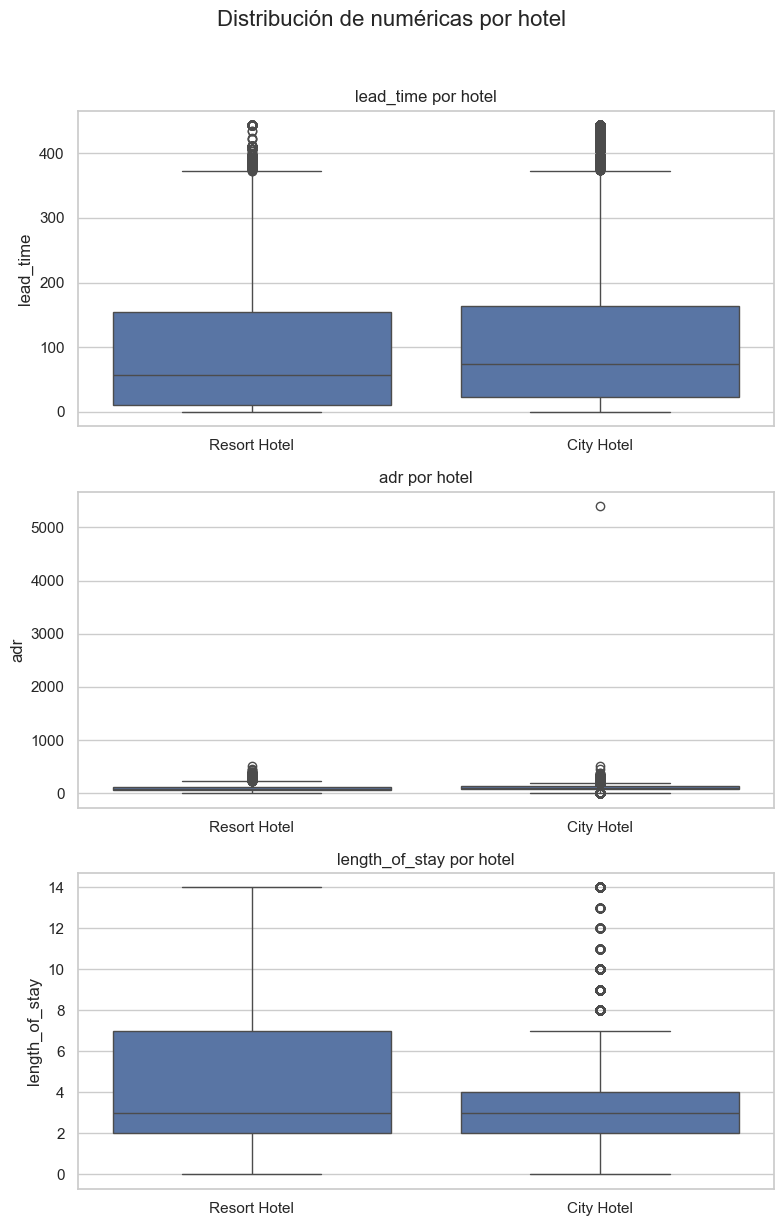

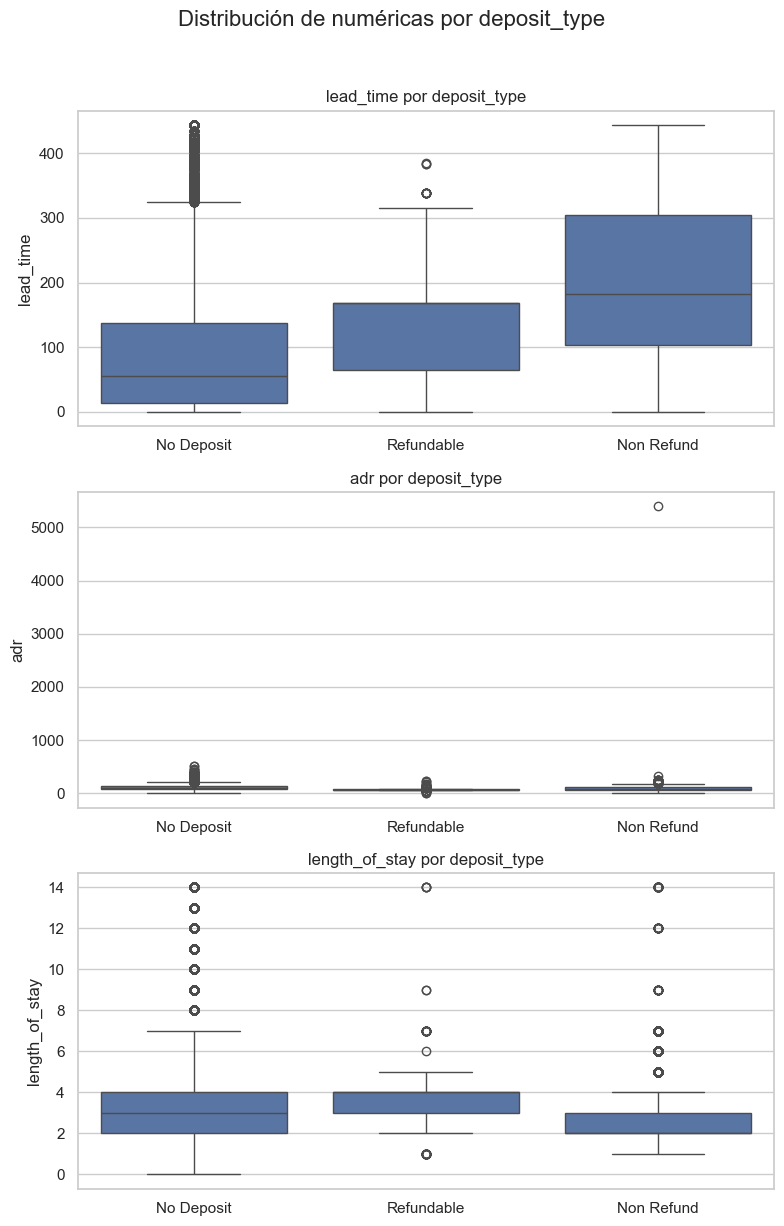

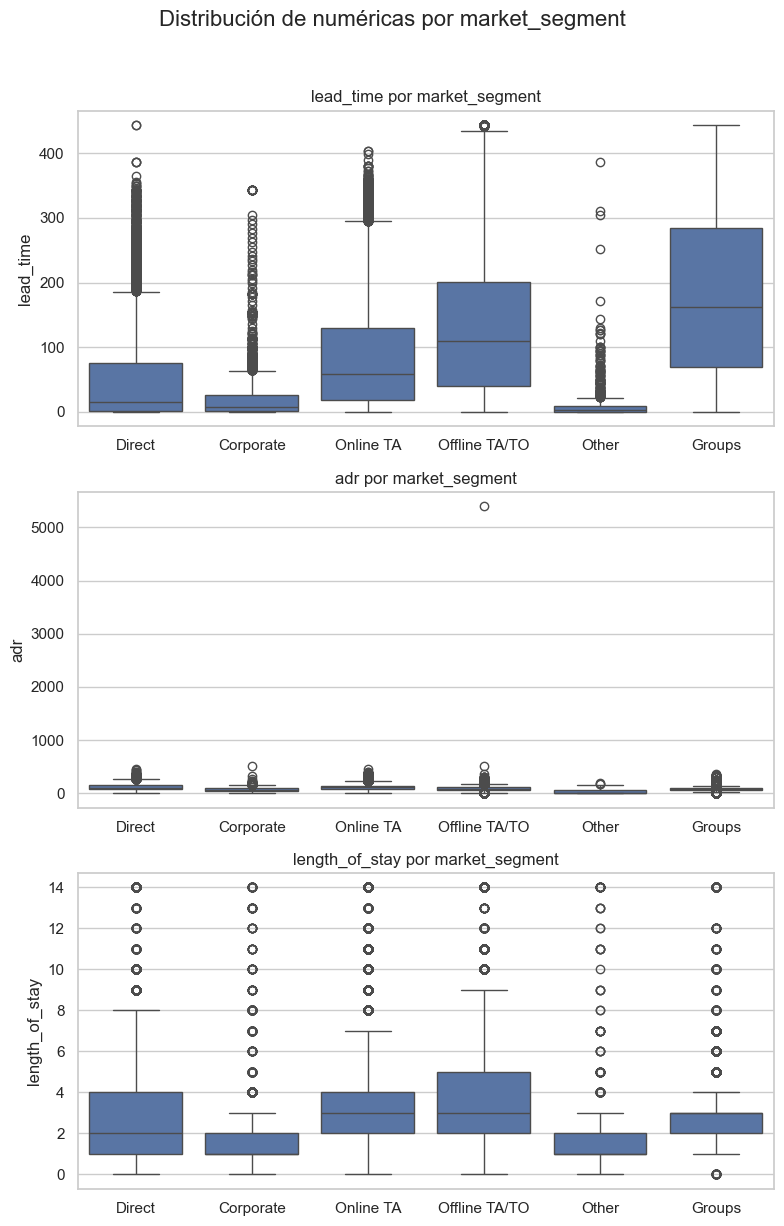

In [72]:
# Boxplots numéricos por nivel de cada categórica
import matplotlib.pyplot as plt
import seaborn as sns

for cat in cat_cols_eda:
    fig, axes = plt.subplots(len(num_cols_eda), 1, figsize=(8, 4*len(num_cols_eda)))
    fig.suptitle(f"Distribución de numéricas por {cat}", y=1.02, fontsize=16)

    for i, num in enumerate(num_cols_eda):
        sns.boxplot(x=cat, y=num, data=df, ax=axes[i])
        axes[i].set_xlabel("")
        axes[i].set_title(f"{num} por {cat}")
        
    plt.tight_layout()
    plt.show()

#### 3.3.3 Resumen de interacciones categórico–numéricas

- **Por hotel**  
  - **City Hotel** presenta un `lead_time` medio algo mayor que **Resort Hotel** (mediana ≈ 70 vs 55 días).  
  - La tarifa media (`adr`) es ligeramente superior en City Hotel.  
  - `length_of_stay` es muy similar, con mediana ≈ 3 noches en ambos.

- **Por deposit_type**  
  - **Non Refund** muestra un `lead_time` sustancialmente más alto (mediana ≈ 180 días) que **Refundable** (~70 días) y **No Deposit** (~55 días).  
  - `adr` no varía mucho entre niveles, aunque los outliers más altos aparecen en Non Refund.  
  - La duración de la estancia es algo menor en Non Refund (median ≈ 2 noches) vs Refundable (~3–4 noches).

- **Por market_segment**  
  - **Groups** tiene el `lead_time` más alto (mediana ≈ 160 días) y también estancias más largas (mediana ≈ 3–4 noches).  
  - **Online TA** y **Offline TA/TO** ocupan posiciones intermedias en `lead_time` y `length_of_stay`.  
  - **Direct** y **Corporate** planifican con menor antelación (medianas ≈ 30–50 días).

> Estas interacciones confirman que las categorías capturan comportamientos temporales y de duración de la reserva:  
> - `deposit_type=Non Refund` y `market_segment=Groups` son los más anticipados,  
> - `hotel` y `market_segment` también influyen en la tarifa y estancia.  
> Nuestro modelo podrá beneficiarse incluyendo estas variables y sus posibles interacciones.

## 4. Justificación del problema y elección de métrica 

### 4.1 Contexto de negocio
La cancelación inesperada de reservas genera dos problemas principales:  
1. **Pérdida de ingresos**: una habitación reservada que no se ocupa supone ingresos cero.  
2. **Ineficiencia operativa**: planificación de personal, catering y recursos no puede ajustarse sin previsión.

Un modelo que anticipe qué reservas tienen alta probabilidad de cancelarse permite:  
- Ajustar dinámicamente la política de overbooking para minimizar huecos vacíos.  
- Ofrecer promociones “last minute” a clientes potenciales.  
- Optimizar la asignación de recursos (personal, limpieza, servicios).

### 4.2 Balance de clases y coste de errores
- En nuestro dataset el split es **63 % no canceladas / 37 % canceladas**.  
- **Falso negativo (FN)**: predecir “no cancelada” cuando sí lo es:  
  - Causa: habitación queda vacía y no ha sido ofertada a tiempo → **pérdida directa de ingresos**.  
- **Falso positivo (FP)**: predecir “cancelada” cuando no lo es:  
  - Causa: no aceptar o reprogramar una reserva válida → **oportunidad de venta perdida** y posible insatisfacción de cliente.

En general, el coste de un FN es mayor (ventas no realizadas) pero un FP también penaliza la satisfacción y la ocupación. Necesitamos un equilibrio.

### 4.3 Elección de métrica principal
Dado el desbalance moderado y los costes de FN y FP, usaremos:

- **F1-score en la clase “cancelada”**  
  - Equilibra precision (minimizar FP) y recall (minimizar FN).  
- **Métricas secundarias**:  
  - **AUC-ROC**: para evaluar la capacidad de ranking global del modelo.  
  - **Precision** y **Recall** por separado, para afinar la política de umbral si cambia el coste relativo de FN/FP.

> Con F1-score como métrica principal garantizamos que el modelo no se incline excesivamente a evitar un tipo de error a costa del otro, ofreciendo un punto óptimo de rendimiento en la práctica de gestión de reservas.  